In [1]:
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.signal as sig
from systemprbm import UnitCell, System

from scipy.interpolate import UnivariateSpline
%matplotlib inline
from ECA_plotting import *

In [2]:
from matplotlib.animation import FuncAnimation

In [3]:
# Define mechanism parameters
E = 2.2e9 #Young's modulus
t = 0.4e-3 #thickness
b = 5e-3    #width
Lf1 = 6e-3 #length of the flexure on end effector, and bifurcation
Lf2 = 4e-3 #length of the flexure on signal routing and bistable beams
Lr1 = 35e-3 #length of the rigid link on end effector
Lr2 = 24e-3 #length of the rigid link on bistable beams
Lr3 = 35e-3 #length of the rigid link on signal routing
Lr4 = 60e-3 #length of the rigid link on bifurcation
Ls1 = 6e-3 #length of the support on bistable beams
ts1 = 2e-3 #thickness of the support on bistable beams
Lsignal = 6e-3 #length of the signal routing spring leg

alpha0 = 24*np.pi/180 #initial angle of the end effector
beta0 = 8*np.pi/180 #initial angle of the bistable beams
gamma0 = 30*np.pi/180 #initial angle of the signal routing
theta0 = 1*np.pi/180 #initial angle of the bifurcation

kf1 = E*b*t**3/12/Lf1
kf2 = E*b*t**3/12/Lf2
kf3 = E*b*t**3/12/Lf2
kf4 = E*b*t**3/12/Lf1

C1 = E*b*ts1**3/Ls1**3 #bistable support stiffness
C2 = 2*E*b*t**3/Lr2**3 #signal routing guiding stiffness
C3 = 0.2*E*b*t**3/Lsignal**3/6 #signal routing stiffness
C4 = 500000 #bifurcation support stiffness

#todo fix these values

K1 = 0
K2 = 0
K3 = 0

tog_offset = 3e-3

params = {
    'L1': Lr1+Lf1,'L2': Lr2+Lf2,'L3': Lr3+Lf2,'L4': Lr4+Lf1,
    'C1': C1,'C2': C2,'C3': C3,'C4': C4,
    'Kf1': kf1,'Kf2': kf2,'Kf3': kf3,'Kf4': kf4,
    'alpha0': alpha0,'beta0': beta0,'gamma0': gamma0,'theta0': theta0,
    'K1': K1,'K2': K2,'K3': K3,
    'tog_offset': tog_offset,
    } 


In [4]:
%run systemprbm.py

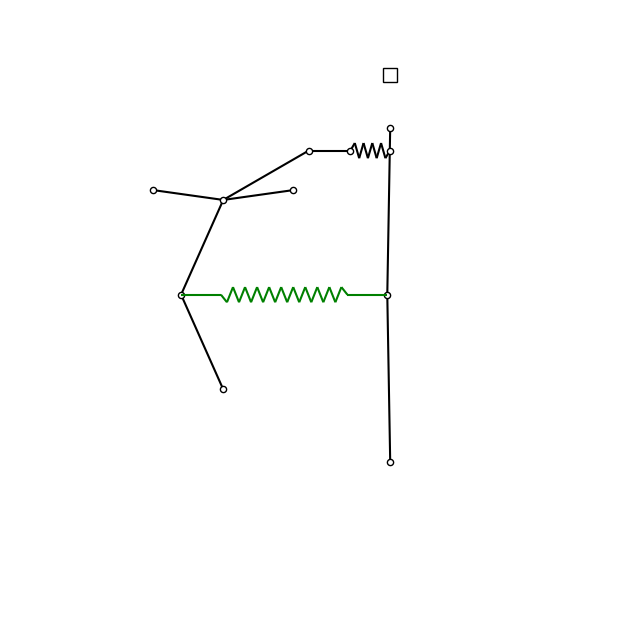

In [5]:
config = [0]
system = System(config,params)
system.cell_spacing = 50e-3
# system.update_state([alpha0,theta0])
fig, ax = system.plot_system()
fig.set_size_inches(6,6)
fig.set_dpi(100)
ax.set_position((0,0,1,1))


# system.tristable_lines
# system.tristable_joints
# system.tristable_joints
# system.signal_router_lines = []
# system.signal_router_joints = []
# system.bifurcation_lines = []
# system.bifurcation_joints = []
# system.signal_spring_lines = []
# system.self_spring_lines = []
# system.left_spring_lines = []
# system.right_spring_lines = []
# system

# ax.collections[0].set_edgecolor('k')
# ax.collections[0].set_linewidth(2)
# ax.collections[1].set_visible(False)
# ax.collections[3].set_visible(True)
# system.signal_router_joints[0].set_visible(False)



In [6]:
def get_force_response():
    config = [0]
    system = System(config, params)
    alpha0 = params['alpha0']
    alpha_range = np.linspace(alpha0, -alpha0, 250)
    force_residuals = np.zeros((len(alpha_range), 2))
    d0 = params['L1']*(np.sin(params['alpha0'])-np.sin(alpha_range))
    bub = np.copy(system.bounds.ub)
    blb = np.copy(system.bounds.lb)

    for i, alpha in enumerate(alpha_range):
    # update the bounds
        blb[0] = alpha
        bub[0] = alpha

        system.bounds.ub = bub
        system.bounds.lb = blb
    # solve for the equilivrium state
        system.solve_equilibrium()

    # get the force residuals
        force_residuals[i] = system.compute_force_residuals()
        force_response = -force_residuals[:, 0]


# find the peaks of the force residuals
    return force_response, d0

force_response,d0 = get_force_response()



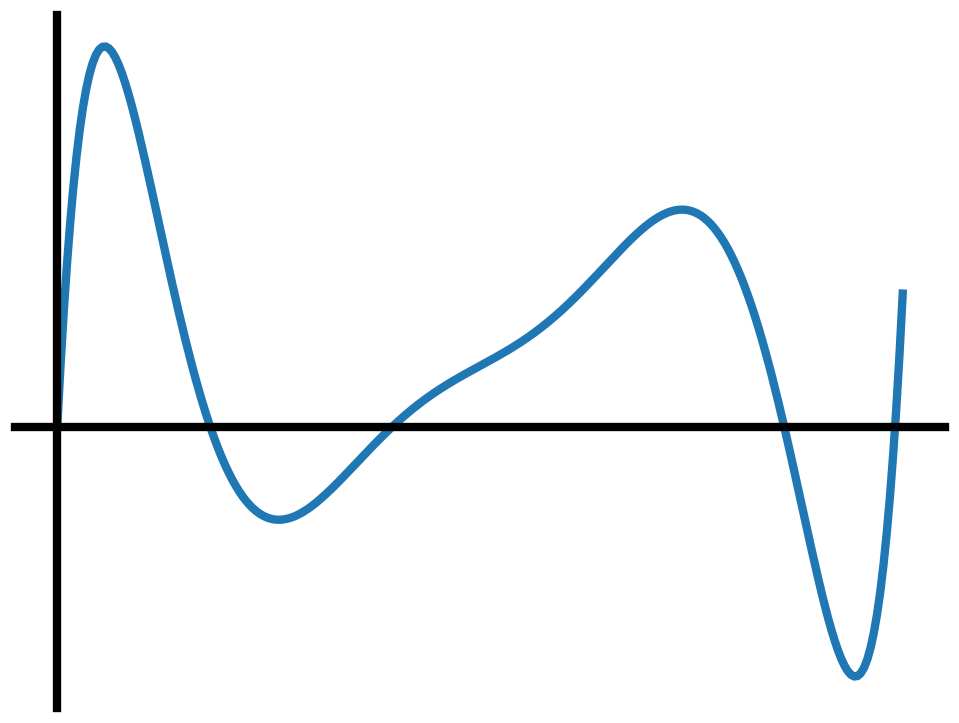

In [7]:

fig = plt.figure(figsize=(8, 6), dpi=150)
ax = fig.add_subplot(111)
plt.plot(d0,force_response,lw=4)
#set no ticks, spine going through the origin, no frame
ax.set_xticks([])
ax.set_yticks([])
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)

# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



<Figure size 640x480 with 0 Axes>

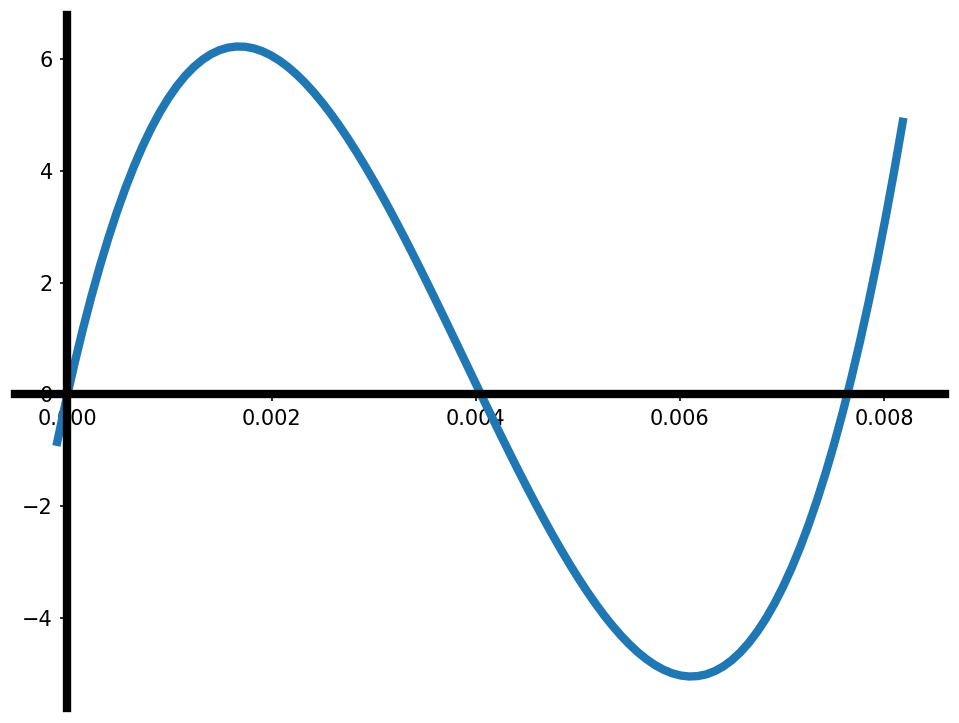

In [9]:
from bistableprbm import Bistable
%run bistableprbm.py

bistable = Bistable(0, params)

d1_range = np.linspace(-0.1e-3,1.05*params['L2']*np.sin(params['beta0'])*2,100)
force = []
for d1 in d1_range:
    bistable.update_state(d1)
    force.append(bistable.compute_force_residuals())
fig,ax = plt.subplots(figsize=(8, 6), dpi=150)
plt.plot(d1_range,force,lw=4)
# ax.set_xticks([])
# ax.set_yticks([])
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)

# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [10]:
def find_tangent_lines(data, target_point):
    x_data, y_data = data[:, 0], data[:, 1]

    # Interpolate the data using a spline
    spline = UnivariateSpline(x_data, y_data, s=0)
    spline_derivative = spline.derivative()
    
    def objective(t):
        y_tangent = spline_derivative(t) * (x_data - t) + spline(t)
        y_at_target = spline_derivative(t) * (target_point[0] - t) + spline(t)
        distance = abs(y_at_target - target_point[1])
        return distance

    # Detect peaks for initial guesses
    peaks, _ = sig.find_peaks(y_data)
    peak_x_values = x_data[peaks]

    results = []
    for initial_guess in peak_x_values:
        result = minimize(objective, initial_guess, bounds=[(initial_guess, 1.1*initial_guess)], constraints={'type': 'ineq', 'fun': lambda t: spline(t)})
        tangent_point = result.x[0]
        tangent_value = spline(tangent_point)
        slope = spline_derivative(tangent_point)
        results.append((tangent_point, tangent_value, slope))
    
    results[0] = (peak_x_values[0], spline(peak_x_values[0]), -spline(peak_x_values[0])/(target_point[0]-peak_x_values[0]))
    return results




In [11]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

ps = powerset([params['K1'],params['K2'],params['K3']])

ps = list(ps)
sums =[sum(x) for x in ps if x]
sums

[0, 0, 0, 0, 0, 0, 0]

In [12]:
%run ECA_plotting.py

<Figure size 640x480 with 0 Axes>

-0.46739519232854154


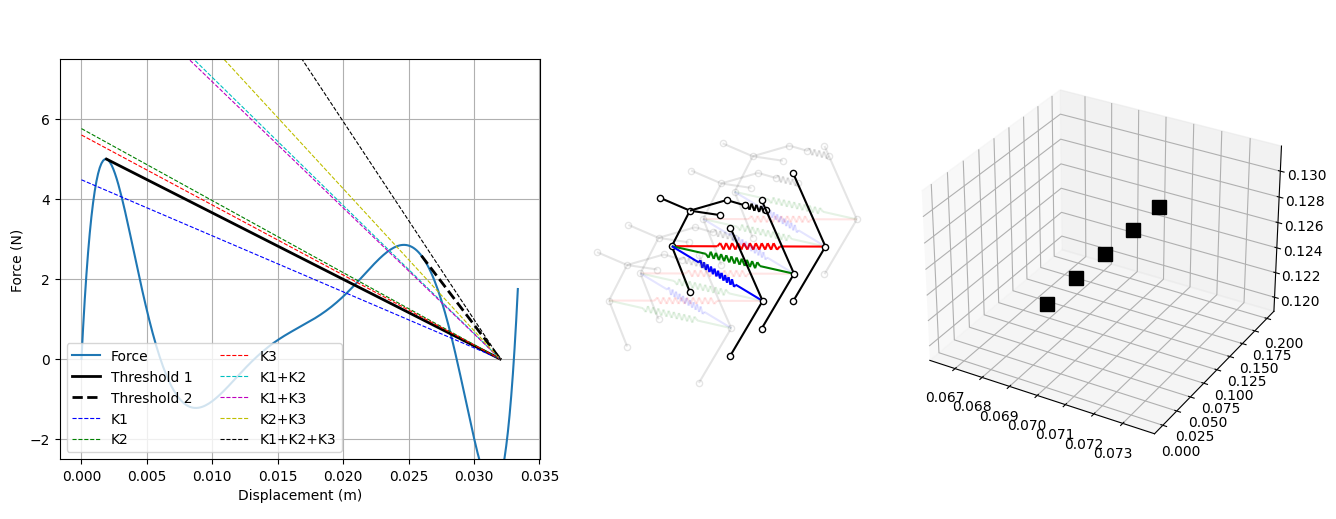

In [19]:
from ECA_plotting import *
params['K1'] = 140
params['K2'] = 180
params['K3'] = 175
d6 = 32e-3
theta_max = np.arcsin(np.sin(params['theta0']-d6/params['L4']))
print(theta_max)


fig = plt.figure(figsize=(16,5))
ax2 = fig.add_subplot(132, projection='3d')
ax1 = fig.add_subplot(131)
ax3 = fig.add_subplot(133,projection='3d')

config = [0,0,0,0,0]
system = System(config,params)
system.cell_spacing = 0.5e-1
x= system.state_vector
x[1::2] = theta_max
system.update_state(x)
system.plot_system(fig= fig, ax=ax2)
ax2.view_init(azim=-60, elev=30)



for i in [0,1,3,4]:
    system.tristable_lines[i].set_alpha(0.1) 
    system.tristable_joints[i].set_alpha(0.1)
    system.signal_router_lines[i].set_alpha(0.1)
    system.signal_router_joints[i].set_alpha(0.1)
    system.signal_spring_lines[i].set_alpha(0.1)
    system.self_spring_lines[i].set_alpha(0.1)
    try:
        system.left_spring_lines[i].set_alpha(0.1)
    except:
        pass
    try:
        system.right_spring_lines[i].set_alpha(0.1)
    except:
        pass
for i in [0,4]:
    system.bifurcation_lines[i].set_alpha(0.1)
    system.bifurcation_joints[i].set_alpha(0.1)



ax1.plot(d0,force_response)
ax1.grid()
ax1.set_xlabel('Displacement (m)')
ax1.set_ylabel('Force (N)')

results = find_tangent_lines(np.column_stack((d0, force_response)),(d6,0))
ax1.plot((results[0][0],d6),(results[0][1],0),'k-',linewidth=2)
ax1.plot((results[1][0],d6),(results[1][1],0),'k--',linewidth=2)

ps = powerset([params['K1'],params['K2'],params['K3']])
ps = list(ps)
sums =[sum(x) for x in ps if x]
colors = ['b','g','r','c','m','y','k']
for c,num in zip(colors,sums):
    ax1.plot((0,d6),(num*d6,0),c+'--',linewidth=0.8)
#set ylimits
ax1.set_ylim([-2.5,7.5])
ax1.legend(['Force','Threshold 1','Threshold 2','K1','K2','K3','K1+K2','K1+K3','K2+K3','K1+K2+K3'], loc='lower left', ncol=2)


#find slopes of lines
m1 = -results[0][2]
m2 = -results[1][2]
# plotSetup(fig=fig, ax=ax3)
# drawCube(ax3)
# plot_cube_with_planes(ax3,[params['K1'],params['K2'],params['K3']],m1,m2)
# ax3.set_xlabel('X1')


ax1.set_position([0.1,0.1,0.3,0.8])
ax2.set_position([0.15,0,0.75,1])
ax3.set_position([0.6,0.1,0.3,0.8])


In [19]:
from scipy.interpolate import interp1d

krange = [75,300]
thickness = interp1d(krange,[0.1,5.0])

In [20]:
def generate_wavelet(n, points, s,w, mid_point,scale=1):
    K1_vals = np.ones(n)
    vec2 = sig.morlet(points, s,w).imag*scale
    p1 = int(mid_point*(n-points))
    K1_vals[p1:p1+points] = vec2+1
    return K1_vals

frames = 300
points = 160
s = 0.5
w = 0.8

params['K1'] = 140
params['K2'] = 180
params['K3'] = 175
K1_vals = params['K1']*generate_wavelet(frames, points, s,w, 0,2)
K2_vals = params['K2']*generate_wavelet(frames, points, s,w, 0.5,2)
K3_vals = params['K3']*generate_wavelet(frames, points, s,w, 1,2)



plt.plot(thickness(K1_vals), label='K1')
plt.plot(thickness(K2_vals), label='K2')
plt.plot(thickness(K3_vals), label='K3')



NameError: name 'params' is not defined

In [36]:
def update(i):

    params['K1'] = K1_vals[i]
    params['K2'] = K2_vals[i]
    params['K3'] = K3_vals[i]
    d6 = d6_vals[i]
    theta_max = np.arcsin(np.sin(params['theta0']-d6/params['L4']))
    state = system.state_vector
    state[1::2] = theta_max
    
    # system.update_plot(0,[state])
    
    

    # d6 = d6_vals[i]
    force_response,d0 = get_force_response()
    ax1.cla()
    ax1.plot(d0,force_response)
    ax1.grid()
    results = find_tangent_lines(np.column_stack((d0, force_response)),(d6,0))
    ax1.plot((results[0][0],d6),(results[0][1],0),'k-',linewidth=2)
    ax1.plot((results[1][0],d6),(results[1][1],0),'k--',linewidth=2)
    ps = list(powerset([params['K1'],params['K2'],params['K3']]))
    sums =[sum(x) for x in ps if x]
    colors = ['b','g','r','c','m','y','k']
    for c,num in zip(colors,sums):
        ax1.plot((0,d6),(num*d6,0),c+'--',linewidth=0.8)
    ax1.set_ylim([-2.5,7.5])
    ax1.legend(['Force','Threshold 1','Threshold 2','K1','K2','K3','K1+K2','K1+K3','K2+K3','K1+K2+K3'], loc='lower left', ncol=2)

    for i in range(system.n):
        system.self_spring_lines[i].set_linewidth(thickness(params['K2']))
        try:
            system.left_spring_lines[i].set_linewidth(thickness(params['K1']))
        except:
            pass
        try:
            system.right_spring_lines[i].set_linewidth(thickness(params['K3']))
        except:
            pass

    ax3.cla()
    m1 = -results[0][2]
    m2 = -results[1][2]

    
    plotSetup(fig=fig, ax=ax3)
    drawCube(ax3)
    plot_cube_with_planes(ax3,[params['K1'],params['K2'],params['K3']],m1,m2)
    
    
    


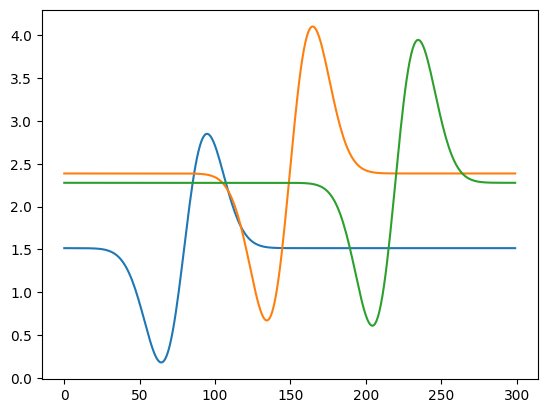

In [39]:
frames = 300
points = 160
s = 0.5
w = 0.8

params['K1'] = 140
params['K2'] = 180
params['K3'] = 175
K1_vals = params['K1']*generate_wavelet(frames, points, s,w, 0,2)
K2_vals = params['K2']*generate_wavelet(frames, points, s,w, 0.5,2)
K3_vals = params['K3']*generate_wavelet(frames, points, s,w, 1,2)
d6_vals = d6*np.ones(frames)


plt.plot(thickness(K1_vals), label='K1')
plt.plot(thickness(K2_vals), label='K2')
plt.plot(thickness(K3_vals), label='K3')

ani = FuncAnimation(fig, update, frames=len(K1_vals), interval=100, repeat=False)
ani.save('dstiffness_sweep.mp4',writer='ffmpeg',fps=30)

In [38]:
params['K1'] = 140
params['K2'] = 180
params['K3'] = 175

frames = 200
points = 200
s = 0.5
w = 0.8
d6_vals = d6*generate_wavelet(frames, points, s,w, 0,0.2)
K1_vals = params['K1']*np.ones(frames)
K2_vals = params['K2']*np.ones(frames)
K3_vals = params['K3']*np.ones(frames)



In [34]:
ani = FuncAnimation(fig, update, frames=len(K1_vals), interval=100, repeat=False)

In [35]:
ani.save('d6_sweep.mp4',writer='ffmpeg',fps=30)

[(0.0019224025784862623, array(4.99679854), -166.13029300090426), (0.025983494596529152, array(2.58355102), array(-429.41044865))]
[(0.0019224025784862623, array(4.99679854), -166.13029300090426), (0.025983494596529152, array(2.58355102), array(-429.41044865))]
[(0.0019224025784862623, array(4.99679854), -166.1303098932099), (0.025983447347005056, array(2.58357131), array(-429.39270341))]
[(0.0019224025784862623, array(4.99679854), -166.13033200453077), (0.02598348687556829, array(2.58355433), array(-429.40754893))]
[(0.0019224025784862623, array(4.99679854), -166.13036082993992), (0.025983496969929035, array(2.58355), array(-429.41134002))]
[(0.0019224025784862623, array(4.99679854), -166.1303982583595), (0.025983489241138965, array(2.58355332), array(-429.40843735))]
[(0.0019224025784862623, array(4.99679854), -166.1304466666529), (0.025983499972937203, array(2.58354871), array(-429.41246785))]
[(0.0019224025784862623, array(4.99679854), -166.13050903362026), (0.02598349921375467, ar

ECA Plotting

In [12]:
%run ECA_plotting.py

<Figure size 640x480 with 0 Axes>

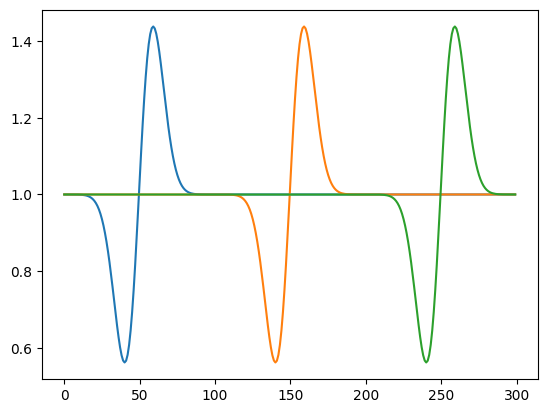

In [22]:
frames = 300
points = 100
s = 0.5
w = 0.8


K1_vals = generate_wavelet(frames, points, s,w, 0,2)
K2_vals = generate_wavelet(frames, points, s,w, 0.5,2)
K3_vals = generate_wavelet(frames, points, s,w, 1,2)



plt.plot(K1_vals, label='K1')
plt.plot(K2_vals, label='K2')
plt.plot(K3_vals, label='K3')

Text(0.5, 0, 'B')

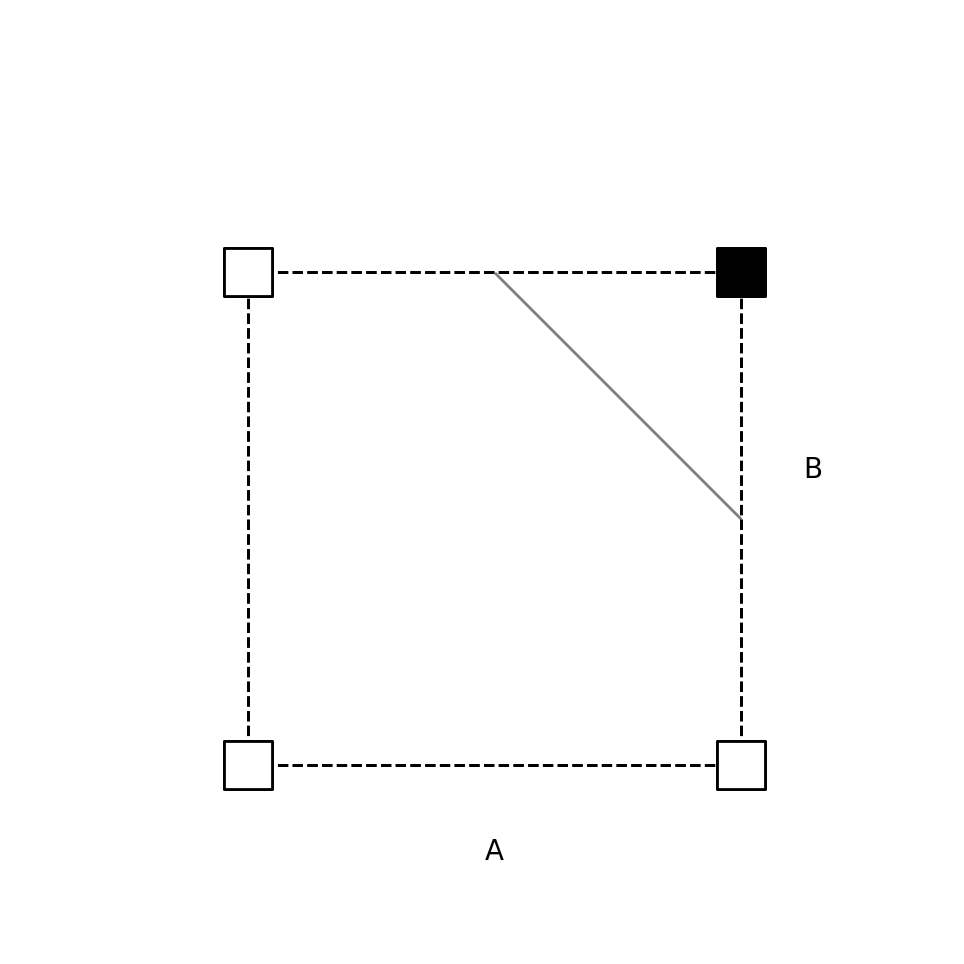

In [15]:
fig,ax = plt.subplots(1,1,figsize=(8, 6), dpi=200,subplot_kw={'projection': '3d'})

plotSetup(fig=fig,ax=ax,proj = 'ortho',elev=0, azim=0)
drawCube(fig.axes[0],r=[0,1])
plns = plot_cube_with_planes(ax,[0,1,1],1.5,10)
ax.set_proj_type('ortho')
ax.set_xlabel('',labelpad=0)
ax.set_ylabel('A',labelpad=0)
ax.set_zlabel('B',labelpad=0)



In [17]:
def update(i):
    if i==1:
        ax.set_xlabel('C',labelpad=0)
    ax.view_init(elev=-.3*i, azim=360-.3*i)

ani = FuncAnimation(fig, update, frames=100, interval=100)
ani.save('test.gif', writer='ffmpeg', fps=30)

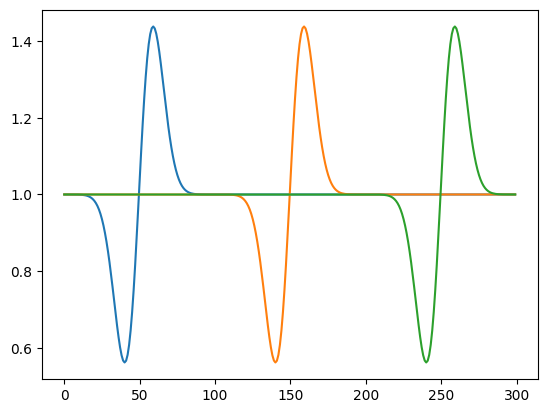

In [30]:
frames = 300
points = 100
s = 0.5
w = 0.8


K1_vals = generate_wavelet(frames, points, s,w, 0,2)
K2_vals = generate_wavelet(frames, points, s,w, 0.5,2)
K3_vals = generate_wavelet(frames, points, s,w, 1,2)



plt.plot(K1_vals, label='K1')
plt.plot(K2_vals, label='K2')
plt.plot(K3_vals, label='K3')

Text(0.5, 0, 'C')

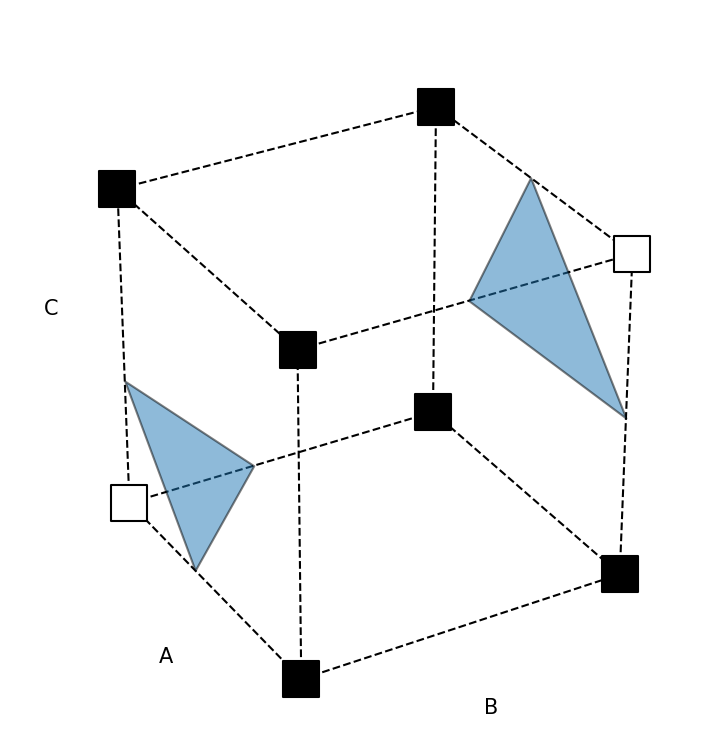

In [44]:
fig,ax = plt.subplots(1,1,figsize=(8, 6), dpi=150,subplot_kw={'projection': '3d'})

plotSetup(fig=fig,ax=ax,proj = 'ortho',elev=30, azim=330)
drawCube(fig.axes[0],r=[0,1])
plns = plot_cube_with_planes(ax,[1,1,1],0.4,2.5)
ax.set_xlabel('A',labelpad=0)
ax.set_ylabel('B',labelpad=0)
ax.set_zlabel('C',labelpad=0)

In [35]:

def update(i):
    ax.cla()

    
    plotSetup(fig=fig,ax=ax,proj = 'ortho',elev=30, azim=300)
    drawCube(ax)
    plot_cube_with_planes(ax,[K1_vals[i],K2_vals[i],K3_vals[i]],1.7,5)

In [1]:
ani = FuncAnimation(fig, update, frames=len(K1_vals), interval=100)
ani.save('stiffness_jiggle.mp4', writer='ffmpeg', fps=5)

NameError: name 'FuncAnimation' is not defined